In [ ]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import statsmodels.api as sm
import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
import os

In [ ]:
# Lista vacía para almacenar los dataframes
directorio ='./'
lista_dataframes = []

# Recorremos todos los archivos en el directorio
for archivo in os.listdir(directorio):
    if archivo.endswith(".csv") and archivo != 'datos_diarios_PVPC_demanda_carburantes.csv' and archivo != 'lags_significativos_tramo_llano.csv' and archivo != 'lags_significativos_tramo_punta.csv' and archivo != 'lags_significativos_tramo_valle.csv':  # Solo archivos .csv
        # Leemos el CSV y lo agregamos a la lista
        df = pd.read_csv(os.path.join(directorio, archivo), sep=';', encoding='utf_16')
        lista_dataframes.append(df)

# Combinamos todos los dataframes en uno solo
df = pd.concat(lista_dataframes, ignore_index=True)
df.head()
# Reemplazar comas por puntos en las columnas de temperaturas y convertirlas a numérico
df['Temp Media (ºC)'] = df['Temp Media (ºC)'].str.replace(',', '.').astype(float)
df['Temp Max (ºC)'] = df['Temp Max (ºC)'].str.replace(',', '.').astype(float)
df['Temp Mínima (ºC)'] = df['Temp Mínima (ºC)'].str.replace(',', '.').astype(float)
df['Humedad Media (%)'] = df['Humedad Media (%)'].str.replace(',', '.').astype(float)
df['Radiación (MJ/m2)'] = df['Radiación (MJ/m2)'].str.replace(',', '.').astype(float)
df['Precipitación (mm)'] = df['Precipitación (mm)'].str.replace(',', '.').astype(float)

# Eliminar las columnas 'IdProvincia' y 'IdEstacion'
df = df.drop(columns=['IdProvincia', 'IdEstacion', 'Ano', 'Dia', 'PePMon'])
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')

df.set_index('Fecha', inplace=True)
df_grouped = df.groupby(df.index).mean()
print(df_grouped)

luz = pd.read_csv('datos_diarios_PVPC_demanda_carburantes.csv')
print(luz)

            Temp Media (ºC)  Temp Max (ºC)  Temp Mínima (ºC)  \
Fecha                                                          
2022-10-01        16.036250      25.022500          8.302500   
2022-10-02        18.528750      28.883750          9.766250   
2022-10-03        19.216250      29.028750         11.371250   
2022-10-04        18.682500      28.083750         12.160000   
2022-10-05        19.082500      27.126250         12.256250   
...                     ...            ...               ...   
2024-08-27        24.418571      32.772857         17.201429   
2024-08-28        24.610000      32.275714         16.951429   
2024-08-29        23.358571      29.745714         18.871429   
2024-08-30        23.907143      30.850000         18.555714   
2024-08-31        23.590000      30.792857         19.178571   

            Humedad Media (%)  Radiación (MJ/m2)  Precipitación (mm)  
Fecha                                                                 
2022-10-01          61.21

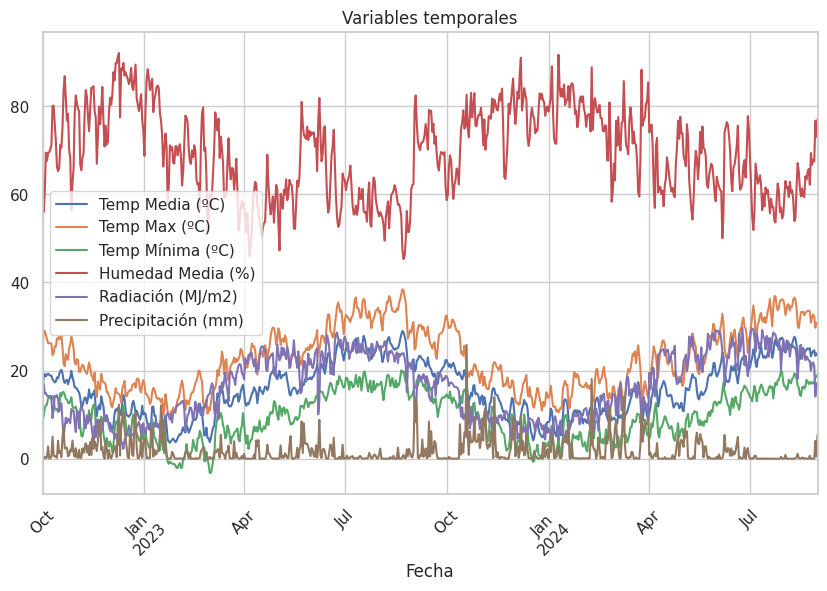

In [ ]:
df_grouped.plot(y=['Temp Media (ºC)', 'Temp Max (ºC)', 'Temp Mínima (ºC)', 'Humedad Media (%)', 'Radiación (MJ/m2)', 'Precipitación (mm)'],
              kind='line', figsize=(10, 6))

# Añadimos título y etiquetas a los ejes
plt.title('Variables temporales')
plt.xlabel('Fecha')

# Mostramos la leyenda para identificar cada línea
plt.legend(loc='best')
plt.grid(True)
plt.xticks(rotation=45)  # Rota las etiquetas de las fechas para que sean legibles

# Mostramos el gráfico
plt.show()

Mean Squared Error: 3332.090595864883


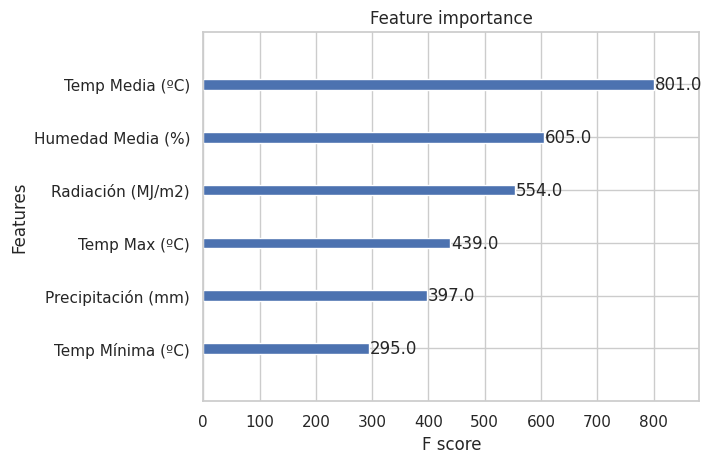

In [ ]:
X = df_grouped[['Temp Media (ºC)', 'Temp Max (ºC)', 'Temp Mínima (ºC)', 'Humedad Media (%)', 'Radiación (MJ/m2)', 'Precipitación (mm)']]
y = luz['PVPC_Llano']
# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Mostrar la importancia de las características
xgb.plot_importance(model)
plt.show()

In [ ]:
df_grouped.reset_index(inplace=True)
df_merged = pd.concat([luz, df_grouped,], axis=1)
df_merged = df_merged.loc[:, ~df_merged.columns.duplicated()]
df_merged = df_merged.drop(columns=['index'])
df_merged.head(3)

,Fecha,Demanda_Llano,Demanda_Punta,Demanda_Valle,PVPC_Llano,PVPC_Punta,PVPC_Valle,Pai Gasolina 95 E5,Pvp Gasolina 95 E5,Pai Gasolina 98 E5,...,Pai Gasóleo A habitual,Pvp Gasóleo A habitual,Pai Gasóleo Premium,Pvp Gasóleo Premium,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Radiación (MJ/m2),Precipitación (mm)
0,2022-10-01,24323.513,24323.513,24323.513,216.937627,216.937627,216.937627,0.943,1.669,1.043,...,1.138,1.795,1.212,1.883,16.03625,25.02250,8.30250,61.21750,16.70000,0.0750
1,2022-10-02,22691.646,22691.646,22691.646,238.561577,238.561577,238.561577,0.943,1.670,1.043,...,1.138,1.795,1.212,1.883,18.52875,28.88375,9.76625,55.98125,17.02625,0.0250
2,2022-10-03,29573.196,31173.437,25146.725,351.282714,432.649761,319.078946,0.944,1.670,1.043,...,1.138,1.795,1.213,1.884,19.21625,29.02875,11.37125,60.53250,14.82625,0.4475


In [ ]:
# Celda 1: Importar bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Excluir la columna 'Fecha' del cálculo de correlaciones
correlations = df_merged.drop(columns=['Fecha'])
# Celda 3: Calcular las correlaciones
correlations = correlations.corr()

# Filtrar las correlaciones que involucran las variables de precio
price_columns = ['PVPC_Llano', 'PVPC_Punta', 'PVPC_Valle']
correlations_with_price = correlations[price_columns].drop(price_columns)

# Mostrar los resultados
print("Correlaciones con las variables de precio:")
print(correlations_with_price)

Correlaciones con las variables de precio:
                        PVPC_Llano  PVPC_Punta  PVPC_Valle
Demanda_Llano             0.511487    0.595173    0.234208
Demanda_Punta             0.507451    0.615764    0.217452
Demanda_Valle             0.343054    0.367000    0.170286
Pai Gasolina 95 E5        0.227820    0.208355    0.272488
Pvp Gasolina 95 E5        0.227250    0.207657    0.272006
Pai Gasolina 98 E5        0.207844    0.192373    0.249789
Pvp Gasolina 98 E5        0.206496    0.190968    0.248314
Pai Gasóleo A habitual    0.372122    0.342122    0.410036
Pvp Gasóleo A habitual    0.371998    0.342024    0.409800
Pai Gasóleo Premium       0.366249    0.337524    0.402601
Pvp Gasóleo Premium       0.365747    0.337053    0.401809
Temp Media (ºC)           0.013246   -0.010814    0.027677
Temp Max (ºC)             0.014815   -0.001875    0.046331
Temp Mínima (ºC)          0.042746    0.007002    0.042435
Humedad Media (%)         0.128428    0.094294    0.099436
Radiación (MJ

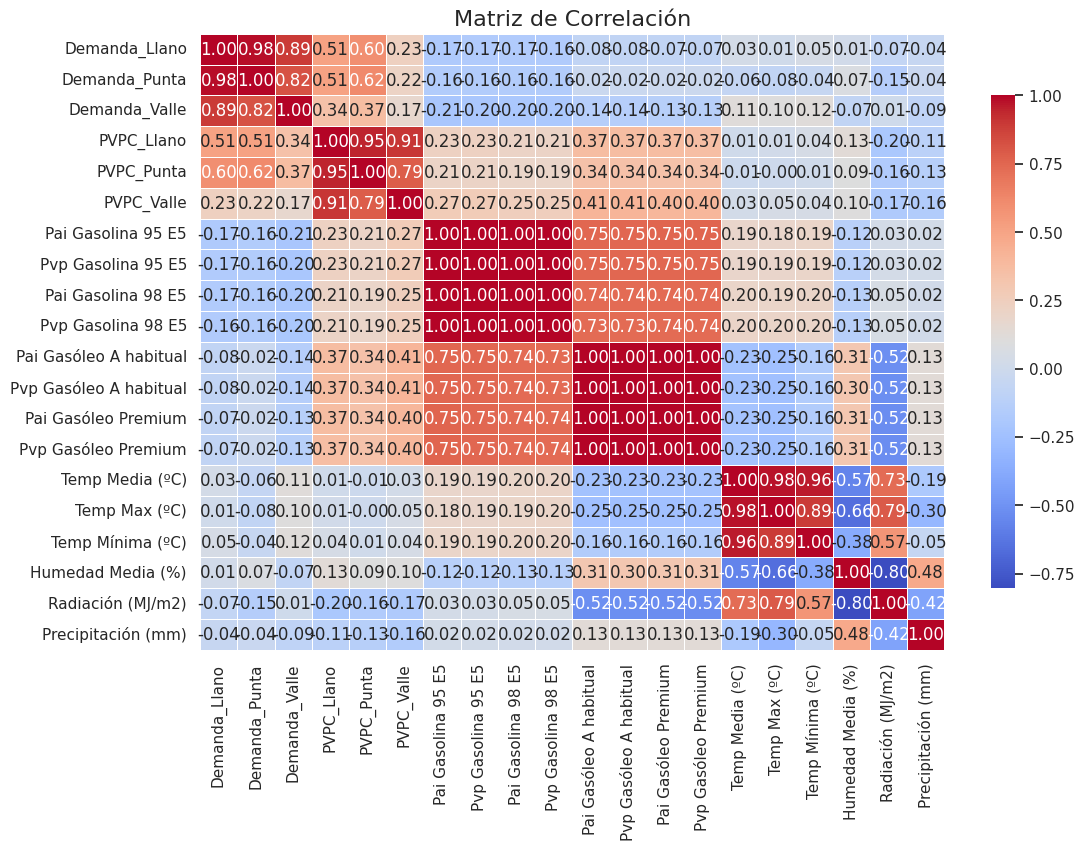

In [ ]:
# Configurar el estilo de seaborn
sns.set_theme(style="whitegrid")
# Celda 4: Crear una matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

<ipython-input-59-880f75deafde>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_with_price.index, y=correlations_with_price[price_column], palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: F

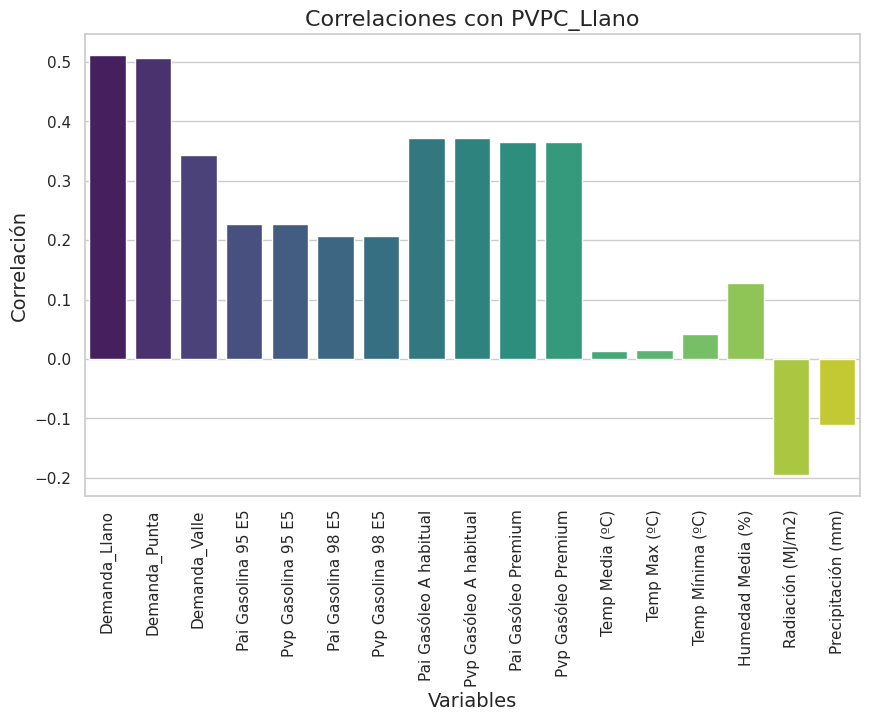

<ipython-input-59-880f75deafde>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_with_price.index, y=correlations_with_price[price_column], palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: F

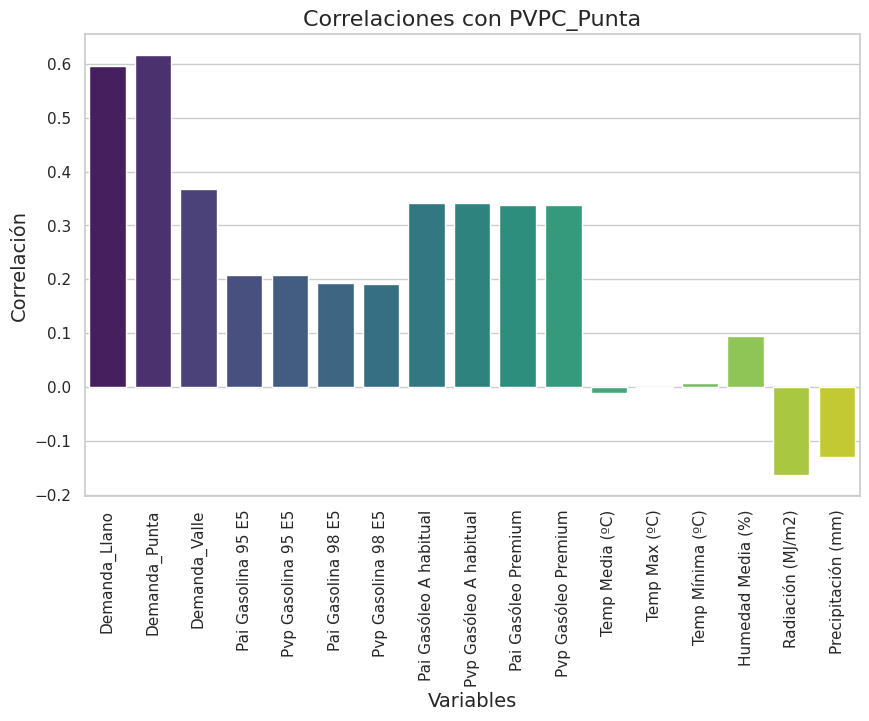

<ipython-input-59-880f75deafde>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_with_price.index, y=correlations_with_price[price_column], palette="viridis")
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: F

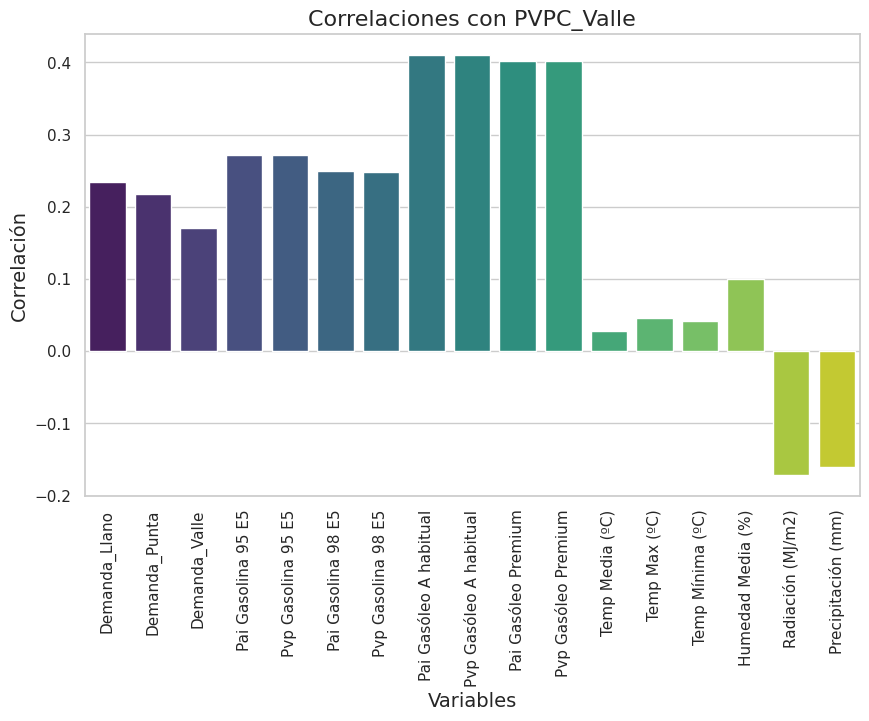

In [ ]:
# Celda 5: Graficar las correlaciones con las variables de precio
for price_column in price_columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlations_with_price.index, y=correlations_with_price[price_column], palette="viridis")
    plt.title(f'Correlaciones con {price_column}', fontsize=16)
    plt.xticks(rotation=90)
    plt.xlabel('Variables', fontsize=14)
    plt.ylabel('Correlación', fontsize=14)
    plt.show()

In [ ]:
df_merged.to_csv('todo.csv', index=False)

In [ ]:
from google.colab import files

files.download('todo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***PREPARACIÓN DE DATOS***



In [ ]:
# ***PREPARACIÓN DE DATOS***

In [ ]:
# Preparación de los datos
# Se espera un fichero con la columna 'fecha', la variable 'y' y, al menos
# una variable exógena
# ==============================================================================
datos = df_merged.rename(columns={'Fecha': 'fecha', 'PVPC_Llano': 'y_1', 'PVPC_Punta': 'y_2', 'PVPC_Valle': 'y_3'})
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d') #Ajustar según el tipo de datos
datos = datos.set_index('fecha')
datos = datos.rename(columns={'Llano': 'y_1', 'Punta': 'y_2', 'Valle': 'y_3'}) # Renombrar columnas en caso de ser necesario
datos = datos.asfreq('D') # Ajustar la frecuencia al tipo de datos
datos = datos.sort_index()
datos.head()

,Demanda_Llano,Demanda_Punta,Demanda_Valle,y_1,y_2,y_3,Pai Gasolina 95 E5,Pvp Gasolina 95 E5,Pai Gasolina 98 E5,Pvp Gasolina 98 E5,...,Pvp Gasóleo A habitual,Pai Gasóleo Premium,Pvp Gasóleo Premium,level_0,Temp Media (ºC),Temp Max (ºC),Temp Mínima (ºC),Humedad Media (%),Radiación (MJ/m2),Precipitación (mm)
fecha,,,,,,,,,,,,,,,,,,,,,
2022-10-01,24323.513,24323.513,24323.513,216.937627,216.937627,216.937627,0.943,1.669,1.043,1.837,...,1.795,1.212,1.883,0,16.03625,25.02250,8.30250,61.21750,16.70000,0.0750
2022-10-02,22691.646,22691.646,22691.646,238.561577,238.561577,238.561577,0.943,1.670,1.043,1.836,...,1.795,1.212,1.883,1,18.52875,28.88375,9.76625,55.98125,17.02625,0.0250
2022-10-03,29573.196,31173.437,25146.725,351.282714,432.649761,319.078946,0.944,1.670,1.043,1.836,...,1.795,1.213,1.884,2,19.21625,29.02875,11.37125,60.53250,14.82625,0.4475
2022-10-04,30106.177,31426.656,26395.682,371.324199,494.452371,362.289320,0.945,1.672,1.043,1.836,...,1.796,1.213,1.884,3,18.68250,28.08375,12.16000,69.48375,14.89500,0.0750
2022-10-05,29999.780,31309.654,26446.464,337.913411,453.173332,359.987677,0.952,1.680,1.050,1.844,...,1.803,1.219,1.891,4,19.08250,27.12625,12.25625,67.65750,14.28750,0.4000


In [ ]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [ ]:
# Generación de conjuntos de datos train-test
# ==============================================================================
steps = 7 # Definir el tamaño del conjunto de test
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2022-10-01 00:00:00 --- 2024-08-24 00:00:00  (n=694)
Fechas test  : 2024-08-25 00:00:00 --- 2024-08-31 00:00:00  (n=7)


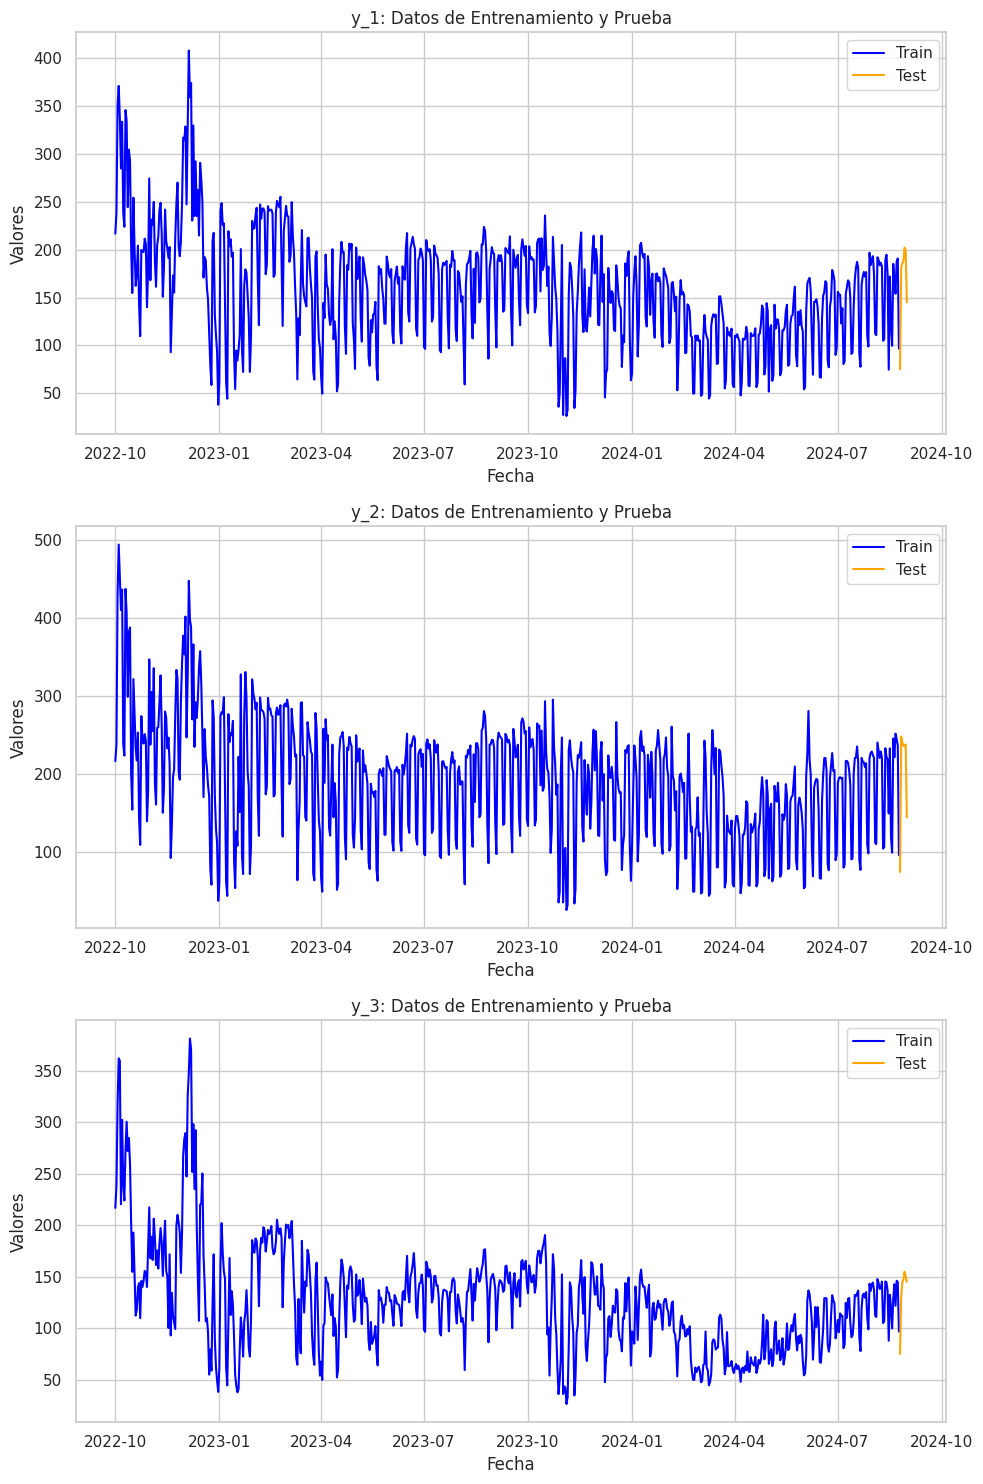

In [ ]:
# Supongamos que ya tienes tus DataFrames: datos_train y datos_test

# Crear una figura con 3 subgráficas (1 columna y 3 filas)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 filas, 1 columna

# Trazar datos para 'y_1'
axs[0].plot(datos_train.index, datos_train['y_1'], label='Train', color='blue')
axs[0].plot(datos_test.index, datos_test['y_1'], label='Test', color='orange')
axs[0].set_title('y_1: Datos de Entrenamiento y Prueba')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Valores')
axs[0].legend()

# Trazar datos para 'y_2'
axs[1].plot(datos_train.index, datos_train['y_2'], label='Train', color='blue')
axs[1].plot(datos_test.index, datos_test['y_2'], label='Test', color='orange')
axs[1].set_title('y_2: Datos de Entrenamiento y Prueba')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valores')
axs[1].legend()

# Trazar datos para 'y_3'
axs[2].plot(datos_train.index, datos_train['y_3'], label='Train', color='blue')
axs[2].plot(datos_test.index, datos_test['y_3'], label='Test', color='orange')
axs[2].set_title('y_3: Datos de Entrenamiento y Prueba')
axs[2].set_xlabel('Fecha')
axs[2].set_ylabel('Valores')
axs[2].legend()

# Ajustar el diseño
plt.tight_layout()

# Mostrar los gráficos
plt.show()

### **EXPERIMENTO #1**

In [ ]:
#'Llano': 'y_1', 'Punta': 'y_2', 'Valle': 'y_3'
lags_y_1 = pd.read_csv('lags_significativos_tramo_llano.csv')['Lag'].values
lags_y_2 = pd.read_csv('lags_significativos_tramo_punta.csv')['Lag'].values
lags_y_3 = pd.read_csv('lags_significativos_tramo_valle.csv')['Lag'].values
lags = {'y_1': lags_y_1, 'y_2': lags_y_2, 'y_3': lags_y_3}